In [1]:
!pip install fancyimpute catboost shap lime

#Libraries

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import ast
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.utils import shuffle
from fancyimpute import IterativeImputer
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Open and load the file from Drive
directory = '/content/drive/MyDrive/Colab Notebooks/Project/'
file_path = directory + 'Book2.csv'
with open(file_path) as f:
    data = pd.read_csv(f)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Columns: 188 entries, Samples to Val
dtypes: float64(185), int64(1), object(2)
memory usage: 138.2+ KB


,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,15298,Prostate cancer,AA,84.85,2.26,1.635,27.75,19.85,34.75,1.69,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,17585,Prostate cancer,EA,87.40,3.18,1.330,23.70,14.20,20.10,2.76,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
2,17848,Case control,EA,157.00,7.33,3.250,43.10,43.10,92.30,3.51,...,402.0,58.9,196.0,141.0,454.0,218.0,341.0,86.1,151.00,302.0
3,17893,Case control,EA,59.30,1.86,1.270,18.40,11.30,13.80,1.16,...,328.0,30.9,124.0,93.0,365.0,131.0,215.0,94.1,101.00,391.0
4,17962,Case control,EA,57.80,1.78,0.781,18.00,12.10,13.20,1.48,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.80,115.0


In [4]:
df = data.copy()

# shuffling the df
shuffled_df = shuffle(df, random_state=42)

# Encoding catergorical data to numerical data
df['Race'] = df['Race'].map({'EA': 0, 'AA': 1})
df['Status'] = df['Status'].map({'Case control': 0, 'Prostate cancer': 1})

df.head()

,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,15298,1,1,84.85,2.26,1.635,27.75,19.85,34.75,1.69,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,17585,1,0,87.40,3.18,1.330,23.70,14.20,20.10,2.76,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
2,17848,0,0,157.00,7.33,3.250,43.10,43.10,92.30,3.51,...,402.0,58.9,196.0,141.0,454.0,218.0,341.0,86.1,151.00,302.0
3,17893,0,0,59.30,1.86,1.270,18.40,11.30,13.80,1.16,...,328.0,30.9,124.0,93.0,365.0,131.0,215.0,94.1,101.00,391.0
4,17962,0,0,57.80,1.78,0.781,18.00,12.10,13.20,1.48,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.80,115.0


In [5]:
df = df.drop(columns=['Samples'])

# Check for NaN values
nan_check = df.isna().sum()
print(nan_check[nan_check > 0])

# Check total number of NaN values in df
total_nan = df.isna().sum().sum()
print("Total number of NaN values in the DataFrame (Before):", total_nan)

df.tail(20)

PC aa C34:4    1
PC aa C36:0    1
PC aa C36:1    1
PC aa C36:2    1
PC aa C36:3    1
              ..
Ser            1
Thr            2
Trp            1
Tyr            1
Val            1
Length: 160, dtype: int64
Total number of NaN values in the DataFrame (Before): 170


,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
74,0,1,54.3,0.827,0.828,18.30,12.00,43.7,1.20,7.64,...,171.0,31.7,75.8,68.1,230.0,103.0,141.0,59.1,72.2,255.0
75,1,0,159.0,4.300,3.930,54.50,39.50,51.4,4.19,11.20,...,268.0,38.8,126.0,111.0,357.0,189.0,194.0,83.3,91.7,345.0
76,1,0,136.0,3.750,2.300,42.30,27.70,60.0,4.50,10.50,...,258.0,29.0,96.7,94.7,455.0,112.0,191.0,71.4,91.1,290.0
77,1,1,118.0,2.930,1.740,30.40,13.50,20.7,2.22,7.49,...,302.0,50.1,112.0,133.0,288.0,149.0,162.0,117.0,142.0,509.0
78,1,1,151.0,4.080,2.100,40.20,24.70,48.4,3.04,12.00,...,283.0,32.7,96.4,107.0,272.0,147.0,146.0,97.7,140.0,416.0
79,1,1,99.4,2.520,2.920,29.30,17.10,20.4,1.80,6.73,...,345.0,46.0,100.0,127.0,276.0,145.0,193.0,88.7,138.0,374.0
80,0,1,106.0,2.280,1.950,36.60,23.10,44.7,2.98,11.10,...,213.0,31.2,82.7,69.0,225.0,101.0,140.0,50.1,59.5,256.0
81,0,1,83.6,2.660,1.200,22.60,15.00,24.6,1.99,6.25,...,281.0,38.5,84.7,98.6,297.0,130.0,186.0,60.9,122.0,269.0
82,1,1,86.6,1.950,1.920,29.50,15.60,24.3,1.98,15.00,...,539.0,49.7,264.0,150.0,326.0,117.0,186.0,138.0,144.0,552.0
83,1,1,215.0,5.010,2.780,74.30,31.80,43.9,5.49,22.30,...,421.0,48.5,209.0,126.0,293.0,174.5,227.5,115.5,141.0,439.5


#NaN Value Treatment

In [6]:
# Using SVR for NaN value treatment
mice_svr_imputer = IterativeImputer(estimator=SVR(C=1.0, epsilon=0.1), max_iter=10, random_state=42)
df_svr_imputed = mice_svr_imputer.fit_transform(df)

imputed_df = pd.DataFrame(df_svr_imputed, columns=df.columns)
imputed_df.tail(20)

,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
74,0.0,1.0,54.3,0.827,0.828,18.30,12.00,43.7,1.20,7.64,...,171.000000,31.700000,75.800000,68.100000,230.000000,103.000000,141.000000,59.100000,72.200000,255.000000
75,1.0,0.0,159.0,4.300,3.930,54.50,39.50,51.4,4.19,11.20,...,268.000000,38.800000,126.000000,111.000000,357.000000,189.000000,194.000000,83.300000,91.700000,345.000000
76,1.0,0.0,136.0,3.750,2.300,42.30,27.70,60.0,4.50,10.50,...,258.000000,29.000000,96.700000,94.700000,455.000000,112.000000,191.000000,71.400000,91.100000,290.000000
77,1.0,1.0,118.0,2.930,1.740,30.40,13.50,20.7,2.22,7.49,...,302.000000,50.100000,112.000000,133.000000,288.000000,149.000000,162.000000,117.000000,142.000000,509.000000
78,1.0,1.0,151.0,4.080,2.100,40.20,24.70,48.4,3.04,12.00,...,283.000000,32.700000,96.400000,107.000000,272.000000,147.000000,146.000000,97.700000,140.000000,416.000000
79,1.0,1.0,99.4,2.520,2.920,29.30,17.10,20.4,1.80,6.73,...,345.000000,46.000000,100.000000,127.000000,276.000000,145.000000,193.000000,88.700000,138.000000,374.000000
80,0.0,1.0,106.0,2.280,1.950,36.60,23.10,44.7,2.98,11.10,...,213.000000,31.200000,82.700000,69.000000,225.000000,101.000000,140.000000,50.100000,59.500000,256.000000
81,0.0,1.0,83.6,2.660,1.200,22.60,15.00,24.6,1.99,6.25,...,281.000000,38.500000,84.700000,98.600000,297.000000,130.000000,186.000000,60.900000,122.000000,269.000000
82,1.0,1.0,86.6,1.950,1.920,29.50,15.60,24.3,1.98,15.00,...,539.000000,49.700000,264.000000,150.000000,326.000000,117.000000,186.000000,138.000000,144.000000,552.000000
83,1.0,1.0,215.0,5.010,2.780,74.30,31.80,43.9,5.49,22.30,...,421.000000,48.500000,209.000000,126.000000,293.000000,174.500000,227.500000,115.500000,141.000000,439.500000


In [7]:
# Check for NaN values
nan_check = imputed_df.isna().sum()
print(nan_check[nan_check > 0])

# Check total number of NaN values in df
total_nan = imputed_df.isna().sum().sum()
print("Total number of NaN values in the DataFrame (after):", total_nan)

imputed_df.tail(10)

Series([], dtype: int64)
Total number of NaN values in the DataFrame (after): 0


,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
84,0.0,1.0,63.0,1.93,0.918,19.30,13.20,29.7,1.95,6.61,...,229.000000,36.700000,84.300000,98.500000,325.000000,143.000000,221.000000,68.800000,129.000000,368.000000
85,0.0,1.0,90.3,2.41,1.470,26.10,14.80,22.3,1.79,7.10,...,307.000000,40.100000,123.000000,82.700000,209.000000,134.000000,167.000000,81.100000,101.000000,340.000000
86,0.0,1.0,74.0,2.26,0.933,20.70,15.00,17.2,1.43,6.18,...,248.000000,33.600000,56.500000,69.800000,219.000000,103.000000,135.000000,47.800000,87.000000,243.000000
87,0.0,1.0,109.5,2.36,1.635,35.75,16.85,24.7,1.87,8.08,...,108.000000,10.500000,65.000000,37.200000,65.400000,50.600000,179.174475,23.500000,31.700000,107.000000
88,0.0,1.0,118.0,3.68,2.090,32.30,19.50,27.8,2.45,8.50,...,275.163729,32.855316,118.136656,94.969598,310.500229,130.985165,179.561988,78.773394,97.413768,302.043187
89,0.0,1.0,137.0,3.00,2.390,47.20,23.50,41.5,2.44,10.60,...,207.000000,22.900000,99.100000,68.500000,200.000000,98.000000,111.000000,60.400000,63.100000,213.000000
90,0.0,1.0,182.0,4.81,2.470,52.60,27.80,46.2,2.81,11.50,...,389.000000,49.300000,201.000000,158.000000,514.000000,136.000000,204.000000,108.000000,140.000000,495.000000
91,0.0,1.0,150.0,3.46,2.260,55.00,29.70,61.0,3.81,15.80,...,312.000000,29.500000,143.000000,117.000000,330.000000,94.600000,155.000000,87.400000,75.200000,348.000000
92,0.0,1.0,133.0,2.74,2.130,45.00,19.80,39.9,2.46,11.40,...,300.000000,35.000000,151.000000,87.100000,510.000000,163.000000,247.000000,73.000000,105.000000,324.000000
93,0.0,1.0,212.0,6.19,2.730,55.10,30.60,40.8,3.61,12.00,...,355.000000,27.900000,170.000000,113.000000,328.000000,153.000000,187.000000,84.300000,86.600000,450.000000


In [8]:
# Save to Excel in Google Drive
file_path = directory + 'clean_data.csv'
imputed_df.to_csv(file_path, index=False)

print(f"Results saved to {file_path}")

Results saved to /content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv


In [9]:
imputed_df

,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,1.0,1.0,84.85,2.26,1.635,27.75,19.85,34.75,1.69,11.25,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,1.0,0.0,87.40,3.18,1.330,23.70,14.20,20.10,2.76,10.20,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
2,0.0,0.0,157.00,7.33,3.250,43.10,43.10,92.30,3.51,12.00,...,402.0,58.9,196.0,141.0,454.0,218.0,341.0,86.1,151.00,302.0
3,0.0,0.0,59.30,1.86,1.270,18.40,11.30,13.80,1.16,4.42,...,328.0,30.9,124.0,93.0,365.0,131.0,215.0,94.1,101.00,391.0
4,0.0,0.0,57.80,1.78,0.781,18.00,12.10,13.20,1.48,5.43,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.80,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.0,1.0,137.00,3.00,2.390,47.20,23.50,41.50,2.44,10.60,...,207.0,22.9,99.1,68.5,200.0,98.0,111.0,60.4,63.10,213.0
90,0.0,1.0,182.00,4.81,2.470,52.60,27.80,46.20,2.81,11.50,...,389.0,49.3,201.0,158.0,514.0,136.0,204.0,108.0,140.00,495.0
91,0.0,1.0,150.00,3.46,2.260,55.00,29.70,61.00,3.81,15.80,...,312.0,29.5,143.0,117.0,330.0,94.6,155.0,87.4,75.20,348.0
92,0.0,1.0,133.00,2.74,2.130,45.00,19.80,39.90,2.46,11.40,...,300.0,35.0,151.0,87.1,510.0,163.0,247.0,73.0,105.00,324.0


#Filter rows where Status is "Prostate cancer" (1)

In [10]:
df_race = imputed_df[imputed_df['Status'] == 1]
df_race.info()
df_race.head()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 83
Columns: 187 entries, Status to Val
dtypes: float64(187)
memory usage: 64.6 KB


,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,1.0,1.0,84.85,2.26,1.635,27.75,19.85,34.75,1.69,11.25,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,1.0,0.0,87.40,3.18,1.330,23.70,14.20,20.10,2.76,10.20,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
5,1.0,1.0,118.00,2.95,2.420,34.80,23.80,41.90,3.05,10.20,...,338.0,53.1,142.0,126.0,389.0,169.0,230.0,91.4,186.00,411.0
13,1.0,0.0,163.00,11.70,26.700,92.80,16.00,20.00,1.47,5.00,...,342.0,39.5,164.0,132.0,418.0,133.0,159.0,88.9,128.00,304.0
14,1.0,0.0,134.00,6.01,2.600,34.50,25.60,31.20,4.85,14.00,...,399.0,37.6,172.0,122.0,332.0,144.0,146.0,62.0,111.00,399.0


In [11]:
file_path = directory + 'mrmr_results.csv'
mrmr_results = pd.read_csv(file_path)
mrmr_results.info()
mrmr_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   K                   91 non-null     int64  
 1   Accuracy            91 non-null     float64
 2   Feature_Rank        91 non-null     object 
 3   Feature_Importance  91 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.0+ KB


,K,Accuracy,Feature_Rank,Feature_Importance
0,10,0.88889,"{'Thr': 1, 'PC aa C28:1': 2, 'Arg': 3, 'SM (OH...","{'Thr': 0.16755520302205806, 'PC aa C28:1': 0...."
1,11,0.66667,"{'PC ae C44:4': 1, 'Thr': 2, 'SM C18:1': 3, 'A...","{'PC ae C44:4': 0.16274023170554977, 'Thr': 0...."
2,12,0.77778,"{'PC ae C44:4': 1, 'Thr': 2, 'Arg': 3, 'SM C18...","{'PC ae C44:4': 0.15729245273648604, 'Thr': 0...."
3,13,0.77778,"{'Thr': 1, 'PC ae C44:4': 2, 'Arg': 3, 'PC aa ...","{'Thr': 0.1497753343389314, 'PC ae C44:4': 0.1..."
4,14,0.88889,"{'PC ae C44:4': 1, 'Arg': 2, 'Thr': 3, 'PC ae ...","{'PC ae C44:4': 0.12841685586230137, 'Arg': 0...."


In [12]:
# Filter the DataFrame for K = 35
mrmr_35_features ={}
result_row = mrmr_results[mrmr_results['K'] == 35]

# Check if the result_row is not empty and retrieve the dictionary
if not result_row.empty:
    mrmr_35_features_str = result_row['Feature_Rank'].values[0]

    # Convert the string to a dictionary
    mrmr_35_features = ast.literal_eval(mrmr_35_features_str)

    print(mrmr_35_features)
else:
    print("No entry found for K = 35.")

{'SM C20:2': 1, 'Thr': 2, 'Met': 3, 'PC ae C36:1': 4, 'ADMA': 5, 'PC aa C32:2': 6, 'PC ae C44:4': 7, 'Arg': 8, 'PC ae C44:5': 9, 'SM C24:1': 10, 'PC aa C36:5': 11, 'PC aa C28:1': 12, 'SM C18:1': 13, 'PC ae C30:0': 14, 'SM (OH) C14:1': 15, 'PC aa C36:6': 16, 'PC ae C36:2': 17, 'PC ae C36:5': 18, 'SM (OH) C16:1': 19, 'SM (OH) C24:1': 20, 'lysoPC a C16:1': 21, 'PC ae C34:0': 22, 'PC aa C30:0': 23, 'PC ae C30:2': 24, 'trans-OH-Pro': 25, 'Kynurenine': 26, 'lysoPC a C20:4': 27, 'PC aa C38:4': 28, 'PC ae C38:0': 29, 'PC aa C40:4': 30, 'Tyr': 31, 'C4': 32, 'Asp': 33, 'DOPA': 34, 'PEA': 35}


In [13]:
print(mrmr_35_features)
print(f"Length of mrmr_35_features: {len(mrmr_35_features)}")

{'SM C20:2': 1, 'Thr': 2, 'Met': 3, 'PC ae C36:1': 4, 'ADMA': 5, 'PC aa C32:2': 6, 'PC ae C44:4': 7, 'Arg': 8, 'PC ae C44:5': 9, 'SM C24:1': 10, 'PC aa C36:5': 11, 'PC aa C28:1': 12, 'SM C18:1': 13, 'PC ae C30:0': 14, 'SM (OH) C14:1': 15, 'PC aa C36:6': 16, 'PC ae C36:2': 17, 'PC ae C36:5': 18, 'SM (OH) C16:1': 19, 'SM (OH) C24:1': 20, 'lysoPC a C16:1': 21, 'PC ae C34:0': 22, 'PC aa C30:0': 23, 'PC ae C30:2': 24, 'trans-OH-Pro': 25, 'Kynurenine': 26, 'lysoPC a C20:4': 27, 'PC aa C38:4': 28, 'PC ae C38:0': 29, 'PC aa C40:4': 30, 'Tyr': 31, 'C4': 32, 'Asp': 33, 'DOPA': 34, 'PEA': 35}
Length of mrmr_35_features: 35


In [14]:
# Provided dictionaries
dict1 = {'SM C20:2': 1, 'Thr': 2, 'Met': 3, 'PC ae C36:1': 4, 'ADMA': 5, 'PC aa C32:2': 6, 'PC ae C44:4': 7, 'Arg': 8, 'PC ae C44:5': 9, 'SM C24:1': 10, 'PC aa C36:5': 11, 'PC aa C28:1': 12, 'SM C18:1': 13, 'PC ae C30:0': 14, 'SM (OH) C14:1': 15, 'PC aa C36:6': 16, 'PC ae C36:2': 17, 'PC ae C36:5': 18, 'SM (OH) C16:1': 19, 'SM (OH) C24:1': 20, 'lysoPC a C16:1': 21, 'PC ae C34:0': 22, 'PC aa C30:0': 23, 'PC ae C30:2': 24, 'trans-OH-Pro': 25, 'Kynurenine': 26, 'lysoPC a C20:4': 27, 'PC aa C38:4': 28, 'PC ae C38:0': 29, 'PC aa C40:4': 30, 'Tyr': 31, 'C4': 32, 'Asp': 33, 'DOPA': 34, 'PEA': 35}

dict2 = {'SM C20:2': 1, 'Thr': 2, 'Met': 3, 'PC ae C36:1': 4, 'ADMA': 5, 'PC aa C32:2': 6, 'PC ae C44:4': 7, 'Arg': 8, 'PC ae C44:5': 9, 'SM C24:1': 10, 'PC aa C36:5': 11, 'PC aa C28:1': 12, 'SM C18:1': 13, 'PC ae C30:0': 14, 'SM (OH) C14:1': 15, 'PC aa C36:6': 16, 'PC ae C36:2': 17, 'PC ae C36:5': 18, 'SM (OH) C16:1': 19, 'SM (OH) C24:1': 20, 'lysoPC a C16:1': 21, 'PC ae C34:0': 22, 'PC aa C30:0': 23, 'PC ae C30:2': 24, 'trans-OH-Pro': 25, 'Kynurenine': 26, 'lysoPC a C20:4': 27, 'PC aa C38:4': 28, 'PC ae C38:0': 29, 'PC aa C40:4': 30, 'Tyr': 31, 'C4': 32, 'Asp': 33, 'DOPA': 34, 'PEA': 35}

# Check for differences
differences = {key: (dict1[key], dict2[key]) for key in set(dict1) | set(dict2) if dict1.get(key) != dict2.get(key)}

print(differences)

# Convert the dictionaries to DataFrames
df1 = pd.DataFrame(list(dict1.items()), columns=['Key', 'Value'])
df2 = pd.DataFrame(list(dict2.items()), columns=['Key', 'Value'])

# Print the result
print("The two dictionaries are equal:", df1.equals(df2))

{}
The two dictionaries are equal: True


In [15]:
# Get the list of columns from the dictionary
feature_columns = list(mrmr_35_features.keys())

# Create a list of columns to select (features + class column)
columns_to_select = ['Race'] + feature_columns

# Filter the DataFrame
df_35_features = df_race[columns_to_select]
features_35=df_35_features
df_35_features

,Race,SM C20:2,Thr,Met,PC ae C36:1,ADMA,PC aa C32:2,PC ae C44:4,Arg,PC ae C44:5,...,Kynurenine,lysoPC a C20:4,PC aa C38:4,PC ae C38:0,PC aa C40:4,Tyr,C4,Asp,DOPA,PEA
0,1.0,0.459000,226.0,32.50,6.120000,0.862500,3.720,0.215500,149.5,0.939500,...,2.140000,11.250,146.000000,1.54500,2.350000,90.05,0.38350,10.395,0.155500,0.000
1,0.0,0.397000,146.0,26.10,6.870000,0.630000,3.710,0.334000,71.1,1.470000,...,4.410000,10.200,200.000000,1.79000,4.970000,105.00,0.28500,12.200,0.322000,0.000
5,1.0,0.448000,230.0,53.10,9.730000,0.639000,6.270,0.317000,165.0,1.250000,...,2.550000,10.200,158.000000,2.44000,5.080000,186.00,0.20500,16.500,0.304000,0.000
13,0.0,0.124000,159.0,39.50,4.230000,0.891000,0.449,1.310000,100.0,0.968000,...,6.590000,5.000,10.600000,2.97000,2.150000,128.00,0.74100,16.600,0.300000,0.000
14,0.0,0.444000,146.0,37.60,11.000000,0.757000,9.410,0.264000,92.9,1.010000,...,3.560000,14.000,205.000000,3.33000,6.190000,111.00,0.40300,28.200,0.000000,0.000
18,1.0,0.330000,201.0,42.20,6.850000,0.808000,6.570,0.239000,121.0,1.130000,...,3.580000,8.520,152.000000,2.03000,5.810000,134.00,0.21800,27.400,0.301000,0.000
19,1.0,0.811000,184.0,38.90,7.500000,0.660000,4.420,0.266000,143.0,1.150000,...,2.930000,8.300,207.000000,1.82000,6.230000,121.00,0.25000,14.900,0.317000,0.000
21,0.0,0.160000,177.0,24.60,29.000000,0.590000,14.000,0.593000,91.6,2.080000,...,2.110000,10.800,186.000000,3.95000,6.360000,94.50,0.14700,23.900,0.000000,0.000
23,0.0,0.000000,171.0,29.50,7.470000,0.820000,2.000,0.831000,66.7,0.767000,...,3.000000,5.980,38.900000,3.06000,3.010000,91.00,1.36000,17.900,0.000000,0.000
27,1.0,0.522000,293.0,42.50,6.720000,0.730000,4.710,0.277000,151.0,1.560000,...,3.210000,11.300,117.000000,3.70000,2.590000,98.70,0.32900,12.300,0.000000,0.000


In [16]:
X = df_35_features.drop(columns=['Race'])
y = df_35_features['Race']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape, y_test.shape)

(9, 35) (9,)


#classifiers

In [17]:
X_arr = np.array(X)
y_arr = np.array(y)

##cross_validate_model

In [18]:
model_results = {}

def cross_validate_model(model, model_name, X, y, n_splits=10):
    global model_results

    X_arr = np.array(X)
    y_arr = np.array(y)

    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    confusion_matrices = []
    train_accuracies = []
    test_accuracies = []

    print(f"======={model_name}========")

    fold = 1
    for train_index, test_index in kf.split(X_arr):
        X_train, X_test = X_arr[train_index], X_arr[test_index]
        y_train, y_test = y_arr[train_index], y_arr[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate confusion matrix for the test set of this fold
        cm = confusion_matrix(y_test, y_test_pred)
        confusion_matrices.append(cm)

        # Calculate and store training and testing accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Fold {fold} Confusion Matrix:\n{cm}")
        print(f"Fold {fold} Training Accuracy: {train_accuracy:.3f}")
        print(f"Fold {fold} Testing Accuracy: {test_accuracy:.3f}\n")

        fold += 1

    # Aggregate confusion matrices across folds
    total_cm = np.sum(confusion_matrices, axis=0)

    # Calculate average training and testing accuracy
    average_train_accuracy = np.mean(train_accuracies)
    average_test_accuracy = np.mean(test_accuracies)

    print("Aggregated Confusion Matrix:\n", total_cm)
    print(f"Average Training Accuracy: {average_train_accuracy:.3f}")
    print(f"Average Testing Accuracy: {average_test_accuracy:.3f}")

    result_dict = {
        'cm': total_cm,
        'train_accuracy': average_train_accuracy,
        'test_accuracy': average_test_accuracy
    }

    if model_name not in model_results:
        model_results[model_name] = []

    model_results[model_name].append(result_dict)

    return total_cm, average_train_accuracy, average_test_accuracy


##LogisticRegression

In [19]:
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
print(logistic_model.get_params())
cm_log, avg_train_acc_log, avg_test_acc_log = cross_validate_model(logistic_model, "LogisticRegression", X, y)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
=======LogisticRegression========
Fold 1 Confusion Matrix:
[[4 0]
 [0 1]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 1.000

Fold 2 Confusion Matrix:
[[3 0]
 [0 2]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 1.000

Fold 3 Confusion Matrix:
[[2 1]
 [0 2]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.800

Fold 4 Confusion Matrix:
[[1 1]
 [0 3]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.800

Fold 5 Confusion Matrix:
[[2 0]
 [0 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 1.000

Fold 6 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 6 Training Accuracy: 1.000
Fold 6 Testing Accuracy: 1.000

Fold 7 Confusion Matrix:
[[0 1]
 [0 3]]
Fold 7 Training Accu

Logistic Regression with best params

In [20]:
# # Parameter grid for hyperparameter tuning
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'lbfgs'],
#     'max_iter': [100, 200, 500, 1000]
# }

# grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)

# # Fit GridSearchCV to find the best parameters
# grid_search.fit(X, y)

# best_logistic_model = grid_search.best_estimator_
# print(best_logistic_model.get_params())

# best_logistic_model=LogisticRegression(C= 10, max_iter=500, solver='lbfgs', random_state=42)
best_params_logistic={'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
best_logistic_model = LogisticRegression(**best_params_logistic)

cm_log_best, avg_train_acc_log_best, avg_test_acc_log_best = cross_validate_model(best_logistic_model,"best_LogisticRegression", X,y)

=======best_LogisticRegression========
Fold 1 Confusion Matrix:
[[4 0]
 [0 1]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 1.000

Fold 2 Confusion Matrix:
[[3 0]
 [1 1]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.800

Fold 3 Confusion Matrix:
[[2 1]
 [0 2]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.800

Fold 4 Confusion Matrix:
[[2 0]
 [0 3]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 1.000

Fold 5 Confusion Matrix:
[[2 0]
 [0 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 1.000

Fold 6 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 6 Training Accuracy: 1.000
Fold 6 Testing Accuracy: 1.000

Fold 7 Confusion Matrix:
[[0 1]
 [1 2]]
Fold 7 Training Accuracy: 1.000
Fold 7 Testing Accuracy: 0.500

Fold 8 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 8 Training Accuracy: 1.000
Fold 8 Testing Accuracy: 1.000

Fold 9 Confusion Matrix:
[[2 0]
 [0 2]]
Fold 9 Training Accuracy: 1.000
Fold 9 Testing Accuracy: 1.000

Fold 10 Confusion Matrix:

##Random Forest

In [21]:
# # Initialize the Random Forest Classifier
# rf = RandomForestClassifier(n_estimators=100, random_state=42)

# # Fit the model
# rf.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
# mean_cv_score_rf = cv_scores_rf.mean()

# # Make predictions on the test set
# y_pred = rf.predict(X_test)

# # Generate the classification report
# report_rf = classification_report(y_test, y_pred)

# # Calculate accuracy
# accuracy_rf = accuracy_score(y_test, y_pred)

# # # Print the results
# print("Cross-Validation Scores: ", cv_scores_rf)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_rf * 100))
# print("Classification Report:\n", report_rf)
# print("Accuracy: {:.2f}%".format(accuracy_rf * 100))

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cm_rf, avg_train_acc_rf, avg_test_acc_rf = cross_validate_model(rf, "RandomForestClassifier", X, y)

=======RandomForestClassifier========
Fold 1 Confusion Matrix:
[[4 0]
 [1 0]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.800

Fold 2 Confusion Matrix:
[[3 0]
 [0 2]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 1.000

Fold 3 Confusion Matrix:
[[2 1]
 [0 2]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.800

Fold 4 Confusion Matrix:
[[2 0]
 [0 3]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 1.000

Fold 5 Confusion Matrix:
[[1 1]
 [0 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.750

Fold 6 Confusion Matrix:
[[1 0]
 [1 2]]
Fold 6 Training Accuracy: 1.000
Fold 6 Testing Accuracy: 0.750

Fold 7 Confusion Matrix:
[[0 1]
 [2 1]]
Fold 7 Training Accuracy: 1.000
Fold 7 Testing Accuracy: 0.250

Fold 8 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 8 Training Accuracy: 1.000
Fold 8 Testing Accuracy: 1.000

Fold 9 Confusion Matrix:
[[1 1]
 [0 2]]
Fold 9 Training Accuracy: 1.000
Fold 9 Testing Accuracy: 0.750

Fold 10 Confusion Matrix:


In [23]:
# # Set up the parameter grid for Grid Search
# param_grid_rf = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [None, 5, 10, 15],
#     'max_features': [None, 'auto', 'sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf,scoring='accuracy', cv=10, n_jobs=-1, verbose=2)

# # Fit Grid Search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and estimator
# best_params_rf = grid_search.best_params_
# print("Best Parameters: ", best_params_rf)

# # Best estimator from Grid Search
# best_rf = grid_search.best_estimator_
# print(best_rf.get_params())

# best_rf=RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=150, random_state=42)
best_params_rf = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
best_rf = RandomForestClassifier(**best_params_rf)

cm_rf_best, avg_train_acc_rf_best, avg_test_acc_rf_best = cross_validate_model(best_rf,"best_RandomForestClassifier", X,y)

=======best_RandomForestClassifier========
Fold 1 Confusion Matrix:
[[3 1]
 [1 0]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.600

Fold 2 Confusion Matrix:
[[3 0]
 [0 2]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 1.000

Fold 3 Confusion Matrix:
[[2 1]
 [0 2]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.800

Fold 4 Confusion Matrix:
[[2 0]
 [1 2]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.800

Fold 5 Confusion Matrix:
[[1 1]
 [0 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.750

Fold 6 Confusion Matrix:
[[1 0]
 [1 2]]
Fold 6 Training Accuracy: 1.000
Fold 6 Testing Accuracy: 0.750

Fold 7 Confusion Matrix:
[[0 1]
 [2 1]]
Fold 7 Training Accuracy: 1.000
Fold 7 Testing Accuracy: 0.250

Fold 8 Confusion Matrix:
[[0 1]
 [0 3]]
Fold 8 Training Accuracy: 1.000
Fold 8 Testing Accuracy: 0.750

Fold 9 Confusion Matrix:
[[2 0]
 [1 1]]
Fold 9 Training Accuracy: 0.975
Fold 9 Testing Accuracy: 0.750

Fold 10 Confusion Mat

##SVM

In [24]:
# # Initialize the Support Vector Classifier
# svm = SVC(kernel='linear', random_state=42)

# # Fit the model
# svm.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_svm = cross_val_score(svm, X, y, cv=5, scoring='accuracy')
# mean_cv_score_svm = cv_scores_svm.mean()

# # Make predictions on the test set
# y_pred_svm = svm.predict(X_test)

# # Generate the classification report
# report_svm = classification_report(y_test, y_pred_svm)

# # Calculate accuracy
# accuracy_svm = accuracy_score(y_test, y_pred_svm)

# # Print the results
# print("SVM Cross-Validation Scores: ", cv_scores_svm)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_svm * 100))
# print("SVM Classification Report:\n", report_svm)
# print("SVM Accuracy: {:.2f}%".format(accuracy_svm * 100))


In [25]:
# Initialize the Support Vector Classifier
svm = SVC(kernel='linear', random_state=42)

cm_svm, avg_train_acc_svm, avg_test_acc_svm = cross_validate_model(svm,"SVC",X,y)

=======SVC========
Fold 1 Confusion Matrix:
[[4 0]
 [0 1]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 1.000

Fold 2 Confusion Matrix:
[[2 1]
 [1 1]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.600

Fold 3 Confusion Matrix:
[[2 1]
 [0 2]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.800

Fold 4 Confusion Matrix:
[[2 0]
 [0 3]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 1.000

Fold 5 Confusion Matrix:
[[2 0]
 [0 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 1.000

Fold 6 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 6 Training Accuracy: 1.000
Fold 6 Testing Accuracy: 1.000

Fold 7 Confusion Matrix:
[[0 1]
 [1 2]]
Fold 7 Training Accuracy: 1.000
Fold 7 Testing Accuracy: 0.500

Fold 8 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 8 Training Accuracy: 1.000
Fold 8 Testing Accuracy: 1.000

Fold 9 Confusion Matrix:
[[2 0]
 [0 2]]
Fold 9 Training Accuracy: 1.000
Fold 9 Testing Accuracy: 1.000

Fold 10 Confusion Matrix:
[[3 0]
 [0 1]]
Fold

##Decision Tree

In [26]:
# # Initialize the Decision Tree Classifier
# dt = DecisionTreeClassifier(random_state=42)

# # Fit the model
# dt.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_dt = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
# mean_cv_score_dt = cv_scores_dt.mean()

# # Make predictions on the test set
# y_pred_dt = dt.predict(X_test)

# # Generate the classification report
# report_dt = classification_report(y_test, y_pred_dt)

# # Calculate accuracy
# accuracy_dt = accuracy_score(y_test, y_pred_dt)

# # Print the results
# print("Decision Tree Cross-Validation Scores: ", cv_scores_dt)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_dt * 100))
# print("Decision Tree Classification Report:\n", report_dt)
# print("Decision Tree Accuracy: {:.2f}%".format(accuracy_dt * 100))


In [27]:
# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

cm_dt, avg_train_acc_dt, avg_test_acc_dt = cross_validate_model(dt,"DecisionTreeClassifier", X,y)

=======DecisionTreeClassifier========
Fold 1 Confusion Matrix:
[[3 1]
 [0 1]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.800

Fold 2 Confusion Matrix:
[[3 0]
 [2 0]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.600

Fold 3 Confusion Matrix:
[[1 2]
 [0 2]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.600

Fold 4 Confusion Matrix:
[[0 2]
 [1 2]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.400

Fold 5 Confusion Matrix:
[[1 1]
 [1 1]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.500

Fold 6 Confusion Matrix:
[[1 0]
 [1 2]]
Fold 6 Training Accuracy: 1.000
Fold 6 Testing Accuracy: 0.750

Fold 7 Confusion Matrix:
[[1 0]
 [3 0]]
Fold 7 Training Accuracy: 1.000
Fold 7 Testing Accuracy: 0.250

Fold 8 Confusion Matrix:
[[1 0]
 [3 0]]
Fold 8 Training Accuracy: 1.000
Fold 8 Testing Accuracy: 0.250

Fold 9 Confusion Matrix:
[[1 1]
 [0 2]]
Fold 9 Training Accuracy: 1.000
Fold 9 Testing Accuracy: 0.750

Fold 10 Confusion Matrix:


##XGBoost

In [28]:
# # Initialize the XGBoost Classifier
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# # Fit the model
# xgb_model.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
# mean_cv_score_xgb = cv_scores_xgb.mean()

# # Make predictions on the test set
# y_pred_xgb = xgb_model.predict(X_test)

# # Generate the classification report
# report_xgb = classification_report(y_test, y_pred_xgb)

# # Calculate accuracy
# accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# # Print the results
# print("XGBoost Cross-Validation Scores: ", cv_scores_xgb)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_xgb * 100))
# print("XGBoost Classification Report:\n", report_xgb)
# print("XGBoost Accuracy: {:.2f}%".format(accuracy_xgb * 100))


In [29]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
cm_xgb, avg_train_acc_xgb, avg_test_acc_xgb = cross_validate_model(xgb_model,"XGBClassifier",X,y)

=======XGBClassifier========
Fold 1 Confusion Matrix:
[[4 0]
 [1 0]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.800

Fold 2 Confusion Matrix:
[[2 1]
 [1 1]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.600

Fold 3 Confusion Matrix:
[[2 1]
 [1 1]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.600

Fold 4 Confusion Matrix:
[[0 2]
 [0 3]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.600

Fold 5 Confusion Matrix:
[[1 1]
 [1 1]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.500

Fold 6 Confusion Matrix:
[[1 0]
 [1 2]]
Fold 6 Training Accuracy: 1.000
Fold 6 Testing Accuracy: 0.750

Fold 7 Confusion Matrix:
[[0 1]
 [2 1]]
Fold 7 Training Accuracy: 1.000
Fold 7 Testing Accuracy: 0.250

Fold 8 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 8 Training Accuracy: 1.000
Fold 8 Testing Accuracy: 1.000

Fold 9 Confusion Matrix:
[[2 0]
 [0 2]]
Fold 9 Training Accuracy: 1.000
Fold 9 Testing Accuracy: 1.000

Fold 10 Confusion Matrix:
[[2 1]
 [

**LGBM** causing error

In [30]:
# import lightgbm as lgb
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import classification_report, accuracy_score

# # Rename feature columns to avoid special characters
# X_train.columns = [col.replace(' ', '_') for col in X_train.columns]  # Example renaming
# X_test.columns = [col.replace(' ', '_') for col in X_test.columns]

# # Initialize the LightGBM Classifier
# lgb_model = lgb.LGBMClassifier(random_state=42, min_data_in_bin=1, min_data_in_leaf=1)

# # Fit the model
# lgb_model.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_lgb = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy')
# mean_cv_score_lgb = cv_scores_lgb.mean()

# # Make predictions on the test set
# y_pred_lgb = lgb_model.predict(X_test)

# # Generate the classification report
# report_lgb = classification_report(y_test, y_pred_lgb)

# # Calculate accuracy
# accuracy_lgb = accuracy_score(y_test, y_pred_lgb)

# # Print the results
# print("LightGBM Cross-Validation Scores: ", cv_scores_lgb)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_lgb * 100))
# print("LightGBM Classification Report:\n", report_lgb)
# print("LightGBM Accuracy: {:.2f}%".format(accuracy_lgb * 100))


##Naive Bayes

In [31]:
# # Initialize the Naive Bayes Classifier
# nb_model = GaussianNB()

# # Fit the model
# nb_model.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_nb = cross_val_score(nb_model, X, y, cv=5, scoring='accuracy')
# mean_cv_score_nb = cv_scores_nb.mean()

# # Make predictions on the test set
# y_pred_nb = nb_model.predict(X_test)

# # Generate the classification report
# report_nb = classification_report(y_test, y_pred_nb)

# # Calculate accuracy
# accuracy_nb = accuracy_score(y_test, y_pred_nb)

# # Print the results
# print("Naive Bayes Cross-Validation Scores: ", cv_scores_nb)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_nb * 100))
# print("Naive Bayes Classification Report:\n", report_nb)
# print("Naive Bayes Accuracy: {:.2f}%".format(accuracy_nb * 100))


In [32]:
# Initialize the Naive Bayes Classifier
nb_model = GaussianNB()

cm_nb, avg_train_acc_nb, avg_test_acc_nb = cross_validate_model(nb_model,"NaiveBayes", X,y)

=======NaiveBayes========
Fold 1 Confusion Matrix:
[[2 2]
 [0 1]]
Fold 1 Training Accuracy: 0.846
Fold 1 Testing Accuracy: 0.600

Fold 2 Confusion Matrix:
[[3 0]
 [0 2]]
Fold 2 Training Accuracy: 0.821
Fold 2 Testing Accuracy: 1.000

Fold 3 Confusion Matrix:
[[2 1]
 [0 2]]
Fold 3 Training Accuracy: 0.821
Fold 3 Testing Accuracy: 0.800

Fold 4 Confusion Matrix:
[[1 1]
 [0 3]]
Fold 4 Training Accuracy: 0.846
Fold 4 Testing Accuracy: 0.800

Fold 5 Confusion Matrix:
[[1 1]
 [0 2]]
Fold 5 Training Accuracy: 0.800
Fold 5 Testing Accuracy: 0.750

Fold 6 Confusion Matrix:
[[1 0]
 [1 2]]
Fold 6 Training Accuracy: 0.775
Fold 6 Testing Accuracy: 0.750

Fold 7 Confusion Matrix:
[[0 1]
 [1 2]]
Fold 7 Training Accuracy: 0.825
Fold 7 Testing Accuracy: 0.500

Fold 8 Confusion Matrix:
[[0 1]
 [0 3]]
Fold 8 Training Accuracy: 0.825
Fold 8 Testing Accuracy: 0.750

Fold 9 Confusion Matrix:
[[1 1]
 [1 1]]
Fold 9 Training Accuracy: 0.775
Fold 9 Testing Accuracy: 0.500

Fold 10 Confusion Matrix:
[[2 1]
 [0 1

##catboost

In [33]:
# # Initialize the CatBoost Classifier
# catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# # Fit the model
# catboost_model.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_catboost = cross_val_score(catboost_model, X, y, cv=5, scoring='accuracy')
# mean_cv_score_catboost = cv_scores_catboost.mean()

# # Make predictions on the test set
# y_pred_catboost = catboost_model.predict(X_test)

# # Generate the classification report
# report_catboost = classification_report(y_test, y_pred_catboost)

# # Calculate accuracy
# accuracy_catboost = accuracy_score(y_test, y_pred_catboost)

# # Print the results
# print("CatBoost Cross-Validation Scores: ", cv_scores_catboost)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_catboost * 100))
# print("CatBoost Classification Report:\n", report_catboost)
# print("CatBoost Accuracy: {:.2f}%".format(accuracy_catboost * 100))


In [34]:
# Initialize the CatBoost Classifier
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

cm_catboost, avg_train_acc_catboost, avg_test_acc_catboost = cross_validate_model(catboost_model,"CatBoostClassifier",X,y)

=======CatBoostClassifier========
Fold 1 Confusion Matrix:
[[3 1]
 [1 0]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.600

Fold 2 Confusion Matrix:
[[2 1]
 [0 2]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.800

Fold 3 Confusion Matrix:
[[2 1]
 [0 2]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.800

Fold 4 Confusion Matrix:
[[0 2]
 [0 3]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.600

Fold 5 Confusion Matrix:
[[1 1]
 [0 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.750

Fold 6 Confusion Matrix:
[[1 0]
 [1 2]]
Fold 6 Training Accuracy: 1.000
Fold 6 Testing Accuracy: 0.750

Fold 7 Confusion Matrix:
[[0 1]
 [2 1]]
Fold 7 Training Accuracy: 1.000
Fold 7 Testing Accuracy: 0.250

Fold 8 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 8 Training Accuracy: 1.000
Fold 8 Testing Accuracy: 1.000

Fold 9 Confusion Matrix:
[[1 1]
 [0 2]]
Fold 9 Training Accuracy: 1.000
Fold 9 Testing Accuracy: 0.750

Fold 10 Confusion Matrix:
[[2 

##knn

In [35]:
# # Initialize the KNN Classifier
# knn_model = KNeighborsClassifier(n_neighbors=5)

# # Fit the model
# knn_model.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_knn = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')
# mean_cv_score_knn = cv_scores_knn.mean()

# # Make predictions on the test set
# y_pred_knn = knn_model.predict(X_test)

# # Generate the classification report
# report_knn = classification_report(y_test, y_pred_knn)

# # Calculate accuracy
# accuracy_knn = accuracy_score(y_test, y_pred_knn)

# # Print the results
# print("KNN Cross-Validation Scores: ", cv_scores_knn)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_knn * 100))
# print("KNN Classification Report:\n", report_knn)
# print("KNN Accuracy: {:.2f}%".format(accuracy_knn * 100))


In [36]:
# Initialize the KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

cm_knn, avg_train_acc_knn, avg_test_acc_knn = cross_validate_model(knn_model,"KNN",X,y)

=======KNN========
Fold 1 Confusion Matrix:
[[2 2]
 [1 0]]
Fold 1 Training Accuracy: 0.769
Fold 1 Testing Accuracy: 0.400

Fold 2 Confusion Matrix:
[[3 0]
 [1 1]]
Fold 2 Training Accuracy: 0.769
Fold 2 Testing Accuracy: 0.800

Fold 3 Confusion Matrix:
[[0 3]
 [0 2]]
Fold 3 Training Accuracy: 0.821
Fold 3 Testing Accuracy: 0.400

Fold 4 Confusion Matrix:
[[1 1]
 [1 2]]
Fold 4 Training Accuracy: 0.795
Fold 4 Testing Accuracy: 0.600

Fold 5 Confusion Matrix:
[[2 0]
 [1 1]]
Fold 5 Training Accuracy: 0.800
Fold 5 Testing Accuracy: 0.750

Fold 6 Confusion Matrix:
[[1 0]
 [0 3]]
Fold 6 Training Accuracy: 0.800
Fold 6 Testing Accuracy: 1.000

Fold 7 Confusion Matrix:
[[0 1]
 [0 3]]
Fold 7 Training Accuracy: 0.825
Fold 7 Testing Accuracy: 0.750

Fold 8 Confusion Matrix:
[[1 0]
 [2 1]]
Fold 8 Training Accuracy: 0.800
Fold 8 Testing Accuracy: 0.500

Fold 9 Confusion Matrix:
[[2 0]
 [0 2]]
Fold 9 Training Accuracy: 0.775
Fold 9 Testing Accuracy: 1.000

Fold 10 Confusion Matrix:
[[2 1]
 [1 0]]
Fold

#Model Results

In [52]:
print("\nModel Results Summary:")
for model_name, results in model_results.items():
    for idx, result in enumerate(results):
        print(f"Model: {model_name} \n CM: {result['cm']} \n Training Accuracy: {result['train_accuracy']:.3f} \n Testing Accuracy: {result['test_accuracy']:.3f}\n\n")


Model Results Summary:
Model: LogisticRegression 
 CM: [[19  3]
 [ 0 22]] 
 Training Accuracy: 1.000 
 Testing Accuracy: 0.935


Model: best_LogisticRegression 
 CM: [[20  2]
 [ 2 20]] 
 Training Accuracy: 1.000 
 Testing Accuracy: 0.910


Model: RandomForestClassifier 
 CM: [[18  4]
 [ 4 18]] 
 Training Accuracy: 1.000 
 Testing Accuracy: 0.810


Model: best_RandomForestClassifier 
 CM: [[17  5]
 [ 6 16]] 
 Training Accuracy: 0.997 
 Testing Accuracy: 0.745


Model: SVC 
 CM: [[19  3]
 [ 2 20]] 
 Training Accuracy: 1.000 
 Testing Accuracy: 0.890


Model: DecisionTreeClassifier 
 CM: [[13  9]
 [11 11]] 
 Training Accuracy: 1.000 
 Testing Accuracy: 0.540


Model: XGBClassifier 
 CM: [[15  7]
 [ 7 15]] 
 Training Accuracy: 1.000 
 Testing Accuracy: 0.685


Model: NaiveBayes 
 CM: [[13  9]
 [ 3 19]] 
 Training Accuracy: 0.813 
 Testing Accuracy: 0.720


Model: CatBoostClassifier 
 CM: [[13  9]
 [ 4 18]] 
 Training Accuracy: 1.000 
 Testing Accuracy: 0.705


Model: KNN 
 CM: [[14  8]
 [

# train & test model

In [38]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)
y_test_pred = logistic_model.predict(X_test)
y_train_pred = logistic_model.predict(X_train)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
testing_accuracy = accuracy_score(y_test, y_test_pred)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Testing Accuracy: {:.2f}%".format(testing_accuracy * 100))
print("Training Accuracy: {:.2f}%".format(training_accuracy * 100))

(9, 35) (9,)
(35, 35) (35,)
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.67      0.80         3

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9

[[6 0]
 [1 2]]
Testing Accuracy: 88.89%
Training Accuracy: 100.00%


#explanable ai

##SHAP

Variable Importance Plot - Global Interpretation


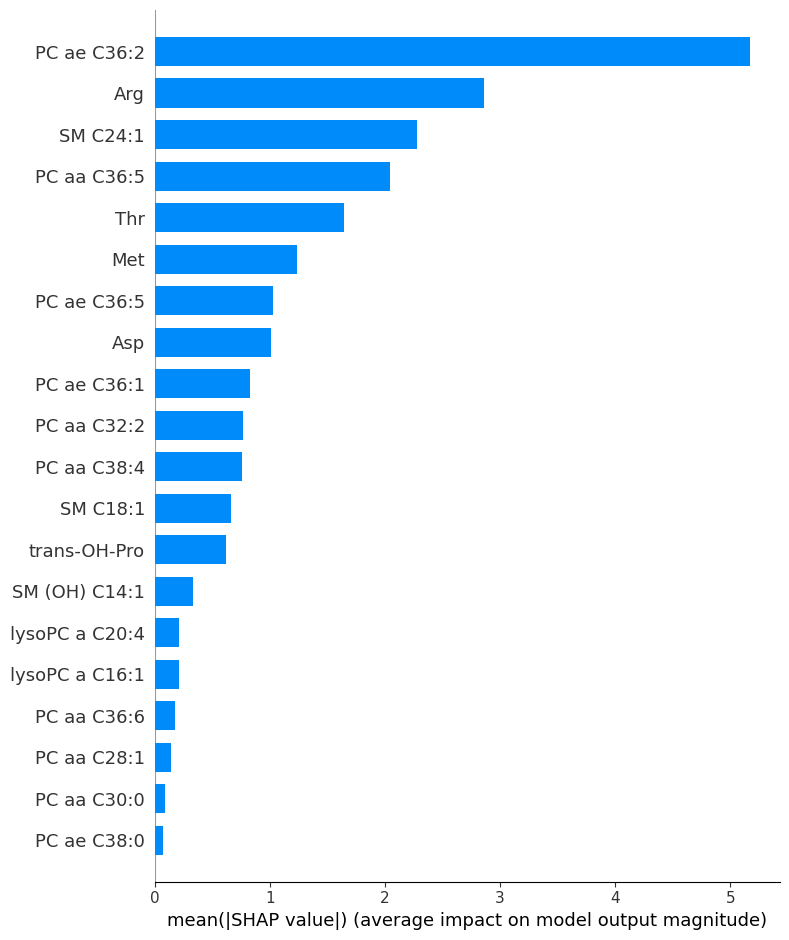

In [39]:
# Create a SHAP explainer
explainer = shap.Explainer(logistic_model, X_train)
shap_values = explainer(X_test)

# Plot SHAP values for the first instance in the test set
shap.initjs()
print("Variable Importance Plot - Global Interpretation")
shap.summary_plot(shap_values, plot_type='bar', show=False)
plt.tight_layout()
plt.show()

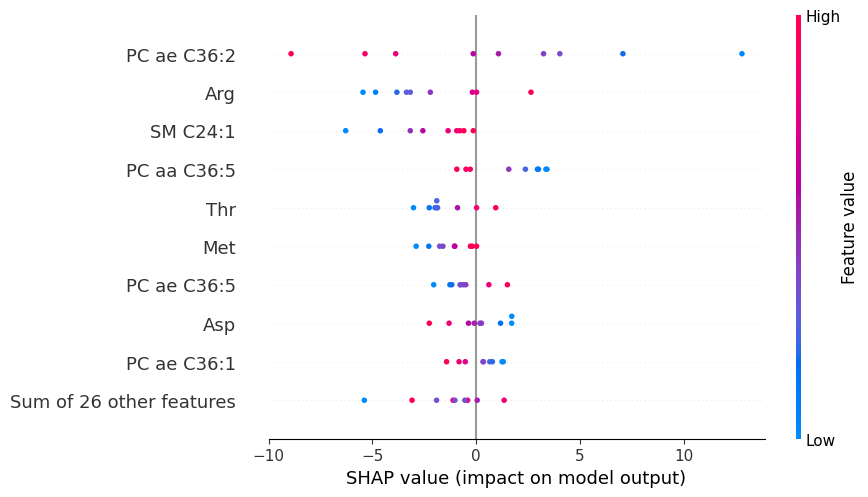

In [40]:
shap.plots.beeswarm(shap_values)

In [41]:
index = 0
shap.initjs()
shap.plots.force(shap_values[index])

In [42]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

print(shap_values_df.iloc[:, :20])
print(shap_values_df.iloc[:, -15:])

   SM C20:2       Thr       Met  PC ae C36:1      ADMA  PC aa C32:2  \
0  0.001048  0.020018  0.015682    -0.826537 -0.002373     0.343187   
1 -0.000502 -2.262057 -1.761646     1.245630  0.001434     0.296413   
2 -0.000506 -3.022749 -2.284390     0.343234 -0.004549     0.264031   
3 -0.000299  0.940856 -1.029805    -1.428134  0.000347    -1.387449   
4 -0.000663 -1.861693 -2.894258     1.305790  0.002179    -0.120954   
5 -0.000003 -1.901730 -1.047230     0.777721  0.001721    -0.941297   
6 -0.000097 -1.901730 -0.193415    -0.525739  0.001205    -1.067227   
7 -0.000304 -1.981803 -0.280539     0.329866  0.000203    -0.847750   
8 -0.002092 -0.900819 -1.604823     0.654060  0.003009     1.598888   

   PC ae C44:4       Arg  PC ae C44:5  SM C24:1  PC aa C36:5  PC aa C28:1  \
0     0.001865  0.018729     0.027250 -0.594834     2.951554    -0.028597   
1     0.006778 -3.178138     0.053825 -4.620707     3.360635     0.173625   
2     0.003685 -3.359664    -0.007751 -0.139075     2.3720

In [43]:
shap_values_array = shap_values.values
print(shap_values_array)

[[ 1.04830268e-03  2.00182078e-02  1.56823114e-02 -8.26537436e-01
  -2.37301658e-03  3.43187128e-01  1.86532500e-03  1.87288287e-02
   2.72503308e-02 -5.94834405e-01  2.95155437e+00 -2.85966011e-02
   5.43749499e-01  1.45038486e-03 -4.44319484e-01  1.11453975e-01
  -8.92480248e+00 -1.17604258e+00 -8.62678992e-02  1.64071631e-03
  -1.31008927e-01 -1.78893612e-02  4.85462454e-02 -2.92745355e-05
  -5.75932925e-01 -1.08878960e-01  1.61645348e-01 -4.58854391e-01
   1.25603318e-01  2.95806449e-03 -6.33506377e-02  2.78796906e-04
   1.70975170e+00  4.04264399e-04 -4.62566224e-08]
 [-5.01508421e-04 -2.26205748e+00 -1.76164631e+00  1.24562989e+00
   1.43432706e-03  2.96413181e-01  6.77779027e-03 -3.17813816e+00
   5.38252146e-02 -4.62070659e+00  3.36063490e+00  1.73624539e-01
  -7.61986374e-01  4.39365201e-03  2.39146716e-01  9.64528272e-02
   4.03049770e+00 -1.26672476e+00  5.82560801e-02  4.38031467e-03
   7.51651936e-02  3.32155621e-02  1.20665945e-01  2.75444865e-04
  -9.14744343e-01  6.8319

##LIME

In [44]:
np.random.seed(42)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['EA', 'AA'],
    mode='classification'
)

# Index of the instance to explain
instance_index = 4
num_features = 10
exp = explainer.explain_instance(
    data_row=X_test.iloc[instance_index].values,
    predict_fn=logistic_model.predict_proba,
    num_features=num_features
)

# Show the explanation
exp.show_in_notebook(show_table=True)

#Odds ratios for each feature

In [45]:
# Odds ratios for each feature
odds_ratios = np.exp(logistic_model.coef_[0])
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logistic_model.coef_[0],
    'Odds Ratio': odds_ratios
}).sort_values(by="Odds Ratio", ascending=False)

print(feature_importance)

           Feature  Coefficient  Odds Ratio
9         SM C24:1     0.379799    1.461991
12        SM C18:1     0.259590    1.296398
2              Met     0.174248    1.190351
17     PC ae C36:5     0.129546    1.138311
7              Arg     0.100848    1.106108
24    trans-OH-Pro     0.086875    1.090760
26  lysoPC a C20:4     0.081976    1.085430
29     PC aa C40:4     0.075648    1.078583
1              Thr     0.040036    1.040849
4             ADMA     0.028627    1.029040
27     PC aa C38:4     0.023101    1.023370
0         SM C20:2     0.004492    1.004502
30             Tyr     0.002948    1.002952
34             PEA     0.000101    1.000101
33            DOPA    -0.003540    0.996466
31              C4    -0.004554    0.995456
23     PC ae C30:2    -0.010157    0.989894
19   SM (OH) C24:1    -0.021743    0.978492
13     PC ae C30:0    -0.040319    0.960483
6      PC ae C44:4    -0.045486    0.955533
21     PC ae C34:0    -0.052148    0.949188
18   SM (OH) C16:1    -0.060470 

#P value

In [46]:
# To get p-values, fit the model with statsmodels
X_train_sm = sm.add_constant(X_train)
# Add constant for intercept
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()
model = sm.Logit(y_train, sm.add_constant(X_train)).fit()

print(result.summary())

         Current function value: 0.000000
         Iterations: 35


LinAlgError: Singular matrix

In [47]:
print(X_train.shape, y_train.shape)
corr_matrix = pd.DataFrame(X_train).corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with high correlation (e.g., > 0.95)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Debug: Print columns to drop
print("Columns to drop due to high correlation:", to_drop)

# Ensure that the columns to drop are present in X_train and X_test
X_train_reduced = X_train.drop(columns=to_drop, errors='ignore')
X_test_reduced = X_test.drop(columns=to_drop, errors='ignore')

# Step 2: Check and Remove Features with High Variance Inflation Factor (VIF)
X_train_reduced_sm = sm.add_constant(X_train_reduced)  # Add constant for intercept
vif_data = pd.DataFrame()
vif_data["VIF Factor"] = [variance_inflation_factor(X_train_reduced_sm.values, i) for i in range(X_train_reduced_sm.shape[1])]
vif_data["features"] = X_train_reduced_sm.columns

# Features with VIF > 10 are often considered highly collinear
high_vif = vif_data[vif_data["VIF Factor"] > 10]["features"].tolist()

# Debug: Print features with high VIF
print("Features with high VIF:", high_vif)

X_train_reduced_vif = X_train_reduced.drop(columns=high_vif, errors='ignore')
X_test_reduced_vif = X_test_reduced.drop(columns=high_vif, errors='ignore')

# Fit the Logistic Regression Model Using statsmodels for p-values
X_train_reduced_vif_sm = sm.add_constant(X_train_reduced_vif)
# Add constant for intercept
logit_model = sm.Logit(y_train, X_train_reduced_vif_sm)

# Fit the model and handle exceptions
try:
    result = logit_model.fit()

    # Print the summary which includes p-values
    print(result.summary())

    # Extract p-values
    p_values = result.pvalues
    print("\nP-values for the features:\n", p_values)

except Exception as e:
    print("Error fitting model:", e)

print("Shape of X_train_reduced_vif:", X_train_reduced_vif.shape)
print("Shape of X_test_reduced_vif:", X_test_reduced_vif.shape)
print("Shape of y_train:", y_train.shape)

# # Train and Evaluate the Model with scikit-learn for Cross-Validation and Metrics
# if X_train_reduced_vif.shape[1] > 0:  # Check if there are any features left
#     logistic_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42, max_iter=1000)
#     logistic_model.fit(X_train_reduced_vif, y_train)

#     # Cross-validation scores
#     cv_scores_logistic = cross_val_score(logistic_model, X_train_reduced_vif, y_train, cv=5, scoring='accuracy')
#     mean_cv_score_logistic = cv_scores_logistic.mean()

#     # Predictions and classification report
#     y_pred_logistic = logistic_model.predict(X_test_reduced_vif)
#     report_logistic = classification_report(y_test, y_pred_logistic)
#     accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

#     # Print sklearn model results
#     print("\nLogistic Regression Cross-Validation Scores:", cv_scores_logistic)
#     print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_logistic * 100))
#     print("Logistic Regression Classification Report:\n", report_logistic)
#     print("Logistic Regression Accuracy: {:.2f}%".format(accuracy_logistic * 100))
# else:
#     print("No features left to train the model after VIF reduction.")

(35, 35) (35,)
Columns to drop due to high correlation: ['PC ae C30:2']
Features with high VIF: ['const', 'SM C20:2', 'Thr', 'Met', 'PC ae C36:1', 'ADMA', 'PC aa C32:2', 'PC ae C44:4', 'Arg', 'PC ae C44:5', 'SM C24:1', 'PC aa C36:5', 'PC aa C28:1', 'SM C18:1', 'PC ae C30:0', 'SM (OH) C14:1', 'PC aa C36:6', 'PC ae C36:2', 'PC ae C36:5', 'SM (OH) C16:1', 'SM (OH) C24:1', 'lysoPC a C16:1', 'PC ae C34:0', 'PC aa C30:0', 'trans-OH-Pro', 'Kynurenine', 'lysoPC a C20:4', 'PC aa C38:4', 'PC ae C38:0', 'PC aa C40:4', 'Tyr', 'C4', 'Asp', 'DOPA', 'PEA']
Optimization terminated successfully.
         Current function value: 0.689469
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                   Race   No. Observations:                   35
Model:                          Logit   Df Residuals:                       34
Method:                           MLE   Df Model:                            0
Date:                Fri, 15 Nov 2

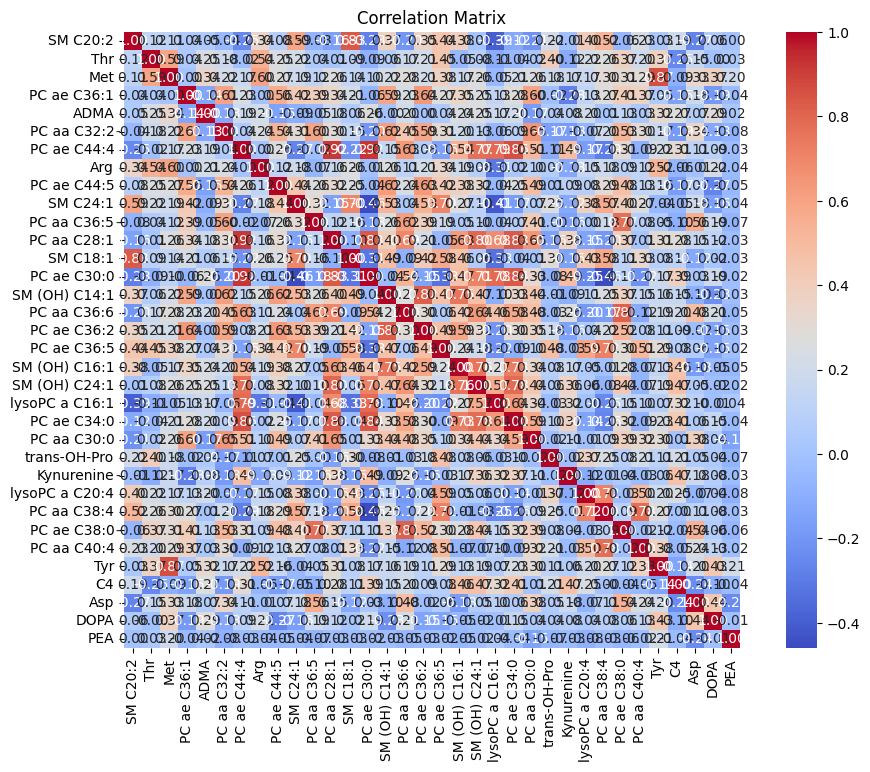

Features in VIF Data:
 ['SM C20:2', 'Thr', 'Met', 'PC ae C36:1', 'ADMA', 'PC aa C32:2', 'PC ae C44:4', 'Arg', 'PC ae C44:5', 'SM C24:1', 'PC aa C36:5', 'PC aa C28:1', 'SM C18:1', 'PC ae C30:0', 'SM (OH) C14:1', 'PC aa C36:6', 'PC ae C36:2', 'PC ae C36:5', 'SM (OH) C16:1', 'SM (OH) C24:1', 'lysoPC a C16:1', 'PC ae C34:0', 'PC aa C30:0', 'trans-OH-Pro', 'Kynurenine', 'lysoPC a C20:4', 'PC aa C38:4', 'PC ae C38:0', 'PC aa C40:4', 'Tyr', 'C4', 'Asp', 'DOPA', 'PEA']
Shape of X_train_reduced_vif (lenient): (35, 13)
Shape of X_test_reduced_vif (lenient): (9, 13)
         Current function value: 0.175708
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                   Race   No. Observations:                   35
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                           13
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:  

In [48]:
# Check the correlation matrix
correlation_matrix = X_train_reduced.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Calculate VIF for all features before dropping
vif_data_all = pd.DataFrame()
vif_data_all["Feature"] = X_train_reduced.columns
vif_data_all["VIF"] = [variance_inflation_factor(X_train_reduced.values, i) for i in range(X_train_reduced.shape[1])]

# Check the features in vif_data_all
print("Features in VIF Data:\n", vif_data_all["Feature"].tolist())
lenient_vif_threshold=825

# Identify features with high VIF to drop based on the lenient threshold
high_vif_features_lenient = vif_data_all[vif_data_all["VIF"] > lenient_vif_threshold]["Feature"].tolist()

# Safely attempt to remove 'const' if it exists
if 'const' in high_vif_features_lenient:
    high_vif_features_lenient.remove('const')  # Exclude the constant

# Drop features with high VIF from the training data
X_train_reduced_vif_lenient = X_train_reduced.drop(columns=high_vif_features_lenient, errors='ignore')
X_test_reduced_vif_lenient = X_test_reduced.drop(columns=high_vif_features_lenient, errors='ignore')

# Check the shape of the reduced datasets with lenient threshold
print("Shape of X_train_reduced_vif (lenient):", X_train_reduced_vif_lenient.shape)
print("Shape of X_test_reduced_vif (lenient):", X_test_reduced_vif_lenient.shape)

# Run logistic regression if there are features left
if X_train_reduced_vif_lenient.shape[1] > 0:
    logit_model_lenient = sm.Logit(y_train, sm.add_constant(X_train_reduced_vif_lenient))  # Add constant again for fitting
    result_lenient = logit_model_lenient.fit()
    print(result_lenient.summary())

else:
    print("No features left to train the model after lenient VIF reduction.")


In [53]:
test = features_35
print(test.shape)

# Identify and remove constant or near-constant features
threshold = 0.01  # This is the threshold for variance
X = test.drop(columns=['Race'])  # Assuming 'Race' is your target variable

# Remove constant features using VarianceThreshold
var_thresh = VarianceThreshold(threshold=threshold)
X_reduced = var_thresh.fit_transform(X)
X = pd.DataFrame(X_reduced, columns=X.columns[var_thresh.get_support()])

# Check how many features were dropped
dropped_features = set(X.columns) - set(test.drop(columns=['Race']).columns)
print("Dropped features due to low variance:", dropped_features)

y = test['Race']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant (intercept)
X_train_const = sm.add_constant(X_train)

# Fit the logistic regression model
try:
    logit_model = sm.Logit(y_train, X_train_const)
    result = logit_model.fit()

    # Print the summary which includes p-values
    print(result.summary())

    # Extracting p-values specifically
    p_values = result.pvalues
    print("P-values for the features:")
    print(p_values)

except Exception as e:
    print(f"Error: {e}")


(44, 36)
Dropped features due to low variance: set()
Error: The indices for endog and exog are not aligned


In [54]:
y = test['Race']  # Dependent variable
X = test.drop(columns=['Race'])  # Independent variables

# Calculate VIF for the independent variables
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop features with high VIF (e.g., VIF > 5)
features_to_keep = vif_data[vif_data['VIF'] < 5]['Feature'].values
X = X[features_to_keep]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print(result.summary())

# Check for convergence warnings and predictions
if not result.converged:
    print("Warning: The model did not converge.")

# Make predictions
predictions = result.predict(X_test)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # Adjust threshold as needed

p_values = result.pvalues
print("P-values for the features:")
print(p_values)

         Current function value: 0.670042
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                   Race   No. Observations:                   30
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            0
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                0.004412
Time:                        00:11:05   Log-Likelihood:                -20.101
converged:                      False   LL-Null:                       -20.190
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PEA          925.0918   1.02e+05      0.009      0.993      -2e+05    2.01e+05
P-values for the features:
PEA    0.992787
dtype: float64


In [55]:
# Fit logistic regression using scikit-learn
logistic_model = LogisticRegression()
# logistic_model = LogisticRegression(penalty='l2')  # Use liblinear for L1

# Define your dependent and independent variables
y = test['Race']  # Dependent variable
X = test.drop(columns=['Race'])  # Independent variables

logistic_model.fit(X, y)

# Get the coefficients
coef = logistic_model.coef_[0]  # Coefficients for the features
intercept = logistic_model.intercept_[0]  # Intercept term

# Use statsmodels to get the standard errors
# Add a constant to the feature set for statsmodels
X_with_const = sm.add_constant(X)

# Calculate predictions using the original model (no constant)
predictions = logistic_model.predict(X)  # Use X without constant for predictions
residuals = y - predictions

# Calculate the variance and standard errors
# Variance of residuals
variance = np.var(residuals, ddof=1)

# Use the design matrix for calculating standard errors
# The design matrix must be for the original features without the constant added for fitting
standard_errors = np.sqrt(np.diagonal(variance * np.linalg.inv(np.dot(X_with_const.T, X_with_const))))

# Calculate z-values and p-values
z_values = coef / standard_errors[1:]  # Exclude the first value (for the intercept)
p_values = [2 * (1 - norm.cdf(np.abs(z))) for z in z_values]  # Use norm from scipy.stats

# Create a DataFrame to display features and their corresponding p-values
feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]
results_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'P-Value': p_values
})

# Create a DataFrame for the intercept
intercept_df = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept], 'P-Value': [None]})

# Concatenate the intercept DataFrame to the results DataFrame
results_df = pd.concat([results_df, intercept_df], ignore_index=True)

print(results_df)
print(X.shape, y.shape)

           Feature  Coefficient  P-Value
0         SM C20:2    -0.004708      0.0
1              Thr    -0.015740      0.0
2              Met     0.463515      0.0
3      PC ae C36:1    -0.329413      0.0
4             ADMA     0.003422      0.0
5      PC aa C32:2    -0.094891      0.0
6      PC ae C44:4    -0.051406      0.0
7              Arg     0.073484      0.0
8      PC ae C44:5    -0.142806      0.0
9         SM C24:1     0.226045      0.0
10     PC aa C36:5    -0.197087      0.0
11     PC aa C28:1    -0.295526      0.0
12        SM C18:1     0.372608      0.0
13     PC ae C30:0    -0.059497      0.0
14   SM (OH) C14:1    -0.429085      0.0
15     PC aa C36:6    -0.108213      0.0
16     PC ae C36:2    -0.933331      0.0
17     PC ae C36:5     0.288955      0.0
18   SM (OH) C16:1    -0.195417      0.0
19   SM (OH) C24:1    -0.058299      0.0
20  lysoPC a C16:1    -0.346660      0.0
21     PC ae C34:0    -0.126351      0.0
22     PC aa C30:0    -0.161708      0.0
23     PC ae C30

#p values for svc

In [56]:
# Fit SVM model with RBF kernel
svm_model = svm

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape, y_test.shape)

# svm_model.fit(X_train, y_train)

# Calculate permutation feature importance
perm_importance = permutation_importance(svm_model, X_test, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})

# Sort by importance
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

print(perm_importance_df)

(9, 35) (9,)
           Feature  Importance       Std
16     PC ae C36:2    0.303704  0.118055
7              Arg    0.144444  0.091400
9         SM C24:1    0.118519  0.085747
10     PC aa C36:5    0.037037  0.052378
3      PC ae C36:1    0.033333  0.050918
24    trans-OH-Pro    0.033333  0.050918
27     PC aa C38:4    0.014815  0.037771
2              Met    0.014815  0.037771
12        SM C18:1    0.014815  0.037771
32             Asp    0.011111  0.033333
23     PC ae C30:2    0.000000  0.000000
25      Kynurenine    0.000000  0.000000
26  lysoPC a C20:4    0.000000  0.000000
0         SM C20:2    0.000000  0.000000
28     PC ae C38:0    0.000000  0.000000
29     PC aa C40:4    0.000000  0.000000
21     PC ae C34:0    0.000000  0.000000
30             Tyr    0.000000  0.000000
31              C4    0.000000  0.000000
33            DOPA    0.000000  0.000000
22     PC aa C30:0    0.000000  0.000000
17     PC ae C36:5    0.000000  0.000000
20  lysoPC a C16:1    0.000000  0.000000
19 